<a href="https://colab.research.google.com/github/Jothish2283/Image_segmentation_unet/blob/main/SemanticSegmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Getting the data**

In [1]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 114.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 50.5 MB/s eta 0

#**Custom dataset**

In [2]:
transformer=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #imagenet

In [3]:
import os
from pathlib import Path
import cv2

class unet_dataset(Dataset):
  def __init__(self, split):
    self.split=split
    self.items=os.listdir(Path(f"/content/dataset1/images_prepped_{self.split}"))

  def __len__(self):
    return len(self.items)

  def __getitem__(self, id):
    image=cv2.imread(f"/content/dataset1/images_prepped_{self.split}/{self.items[id]}", 1)
    image=cv2.resize(image, (224,224))
    mask_file_name=os.listdir(Path(f"/content/dataset1/annotations_prepped_{self.split}"))[id]
    mask=cv2.imread(f"/content/dataset1/annotations_prepped_{self.split}/{mask_file_name}",0)
    mask=cv2.resize(mask, (224,224))
    return image, mask

  def collate_fn(self, batch):
    ims, masks= list(zip(*batch))
    im_batch=torch.cat([transformer(im/255.)[None] for im in ims]).float().to(device)
    mask_batch=torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
    return im_batch, mask_batch

In [4]:
train_dataset=unet_dataset("train")
test_dataset=unet_dataset("test")

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_fn, shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=32, collate_fn=test_dataset.collate_fn)

In [5]:
im, mask=next(iter(train_dataloader))

In [6]:
im.shape, mask.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 224, 224]))

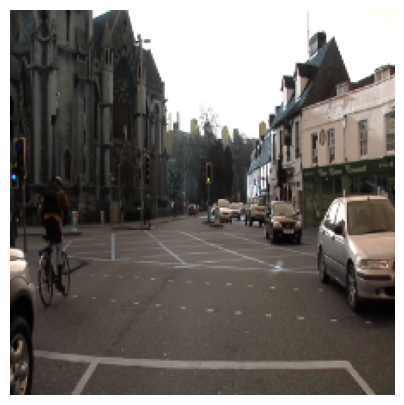

In [7]:
show(train_dataset[25][0])

#**Unet**

In [9]:
!pip -q install torchinfo
from torchinfo import summary

In [10]:
def convblock(in_channels, out_channels):
  layer=torch.nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3,
                                      stride=1, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(p=0.1))
  return layer

In [11]:
def trans_convblock(in_channels, out_channels):
  layer=torch.nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2,
                                               stride=2),
                            nn.ReLU())
  return layer

In [12]:
class UNET(torch.nn.Module):
  def __init__(self, out_channels=12):
    super().__init__()
    self.vgg_model=torchvision.models.vgg16_bn(weights="DEFAULT").features
    self.block_1= nn.Sequential(*self.vgg_model[:6])
    self.block_2= nn.Sequential(*self.vgg_model[6:13])
    self.block_3= nn.Sequential(*self.vgg_model[13:20])
    self.block_4= nn.Sequential(*self.vgg_model[20:27])
    self.block_5= nn.Sequential(*self.vgg_model[27:34])

    self.bottle_neck=nn.Sequential(*self.vgg_model[34:])
    self.conv_bottle_neck=convblock(512, 1024)

    self.trans_conv6=trans_convblock(1024, 512)
    self.conv6=convblock(512+512, 512)
    self.trans_conv7=trans_convblock(512, 256)
    self.conv7=convblock(256+512, 256)
    self.trans_conv8=trans_convblock(256, 128)
    self.conv8=convblock(128+256, 128)
    self.trans_conv9=trans_convblock(128, 64)
    self.conv9=convblock(64+128, 64)
    self.trans_conv10=trans_convblock(64, 32)
    self.conv10=convblock(32+64, 32)
    self.conv11=nn.Conv2d(32, out_channels, kernel_size=1)

    self.cel=nn.CrossEntropyLoss(label_smoothing=0.1)

  def forward(self, x):
    b1=self.block_1(x)
    b2=self.block_2(b1)
    b3=self.block_3(b2)
    b4=self.block_4(b3)
    b5=self.block_5(b4)

    x=self.bottle_neck(b5)
    x=self.conv_bottle_neck(x)

    x=self.trans_conv6(x)
    x=torch.cat([x, b5], dim=1)
    x=self.conv6(x) #these additional conv blocks after catenation helps to smoothen

    x=self.trans_conv7(x)
    x=torch.cat([x, b4], dim=1)
    x=self.conv7(x)

    x=self.trans_conv8(x)
    x=torch.cat([x,b3], dim=1)
    x=self.conv8(x)

    x=self.trans_conv9(x)
    x=torch.cat([x, b2], dim=1)
    x=self.conv9(x)

    x=self.trans_conv10(x)
    x=torch.cat([x, b1], dim=1)
    x=self.conv10(x)

    x=self.conv11(x)

    return x

  def calc_loss(self, im_pred, im_true):
    loss=self.cel(im_pred, im_true)
    acc = (torch.max(im_pred, 1)[1] == im_true).float().mean().item()

    return loss, acc


In [13]:
unet_model=UNET()
summary(unet_model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
UNET                                     [1, 3, 224, 224]          [1, 12, 224, 224]         --                        True
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 64, 224, 224]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 224, 224]         1,792                     True
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         [1, 64, 224, 224]         128                       True
│    └─ReLU: 2-3                         [1, 64, 224, 224]         [1, 64, 224, 224]         --                        --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         [1, 64, 224, 224]         36,928                    True
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         [1, 64, 224, 224]         128                       True
│    

In [14]:
!pip -q install torchview
!pip -q install graphviz
import graphviz
from torchview import draw_graph

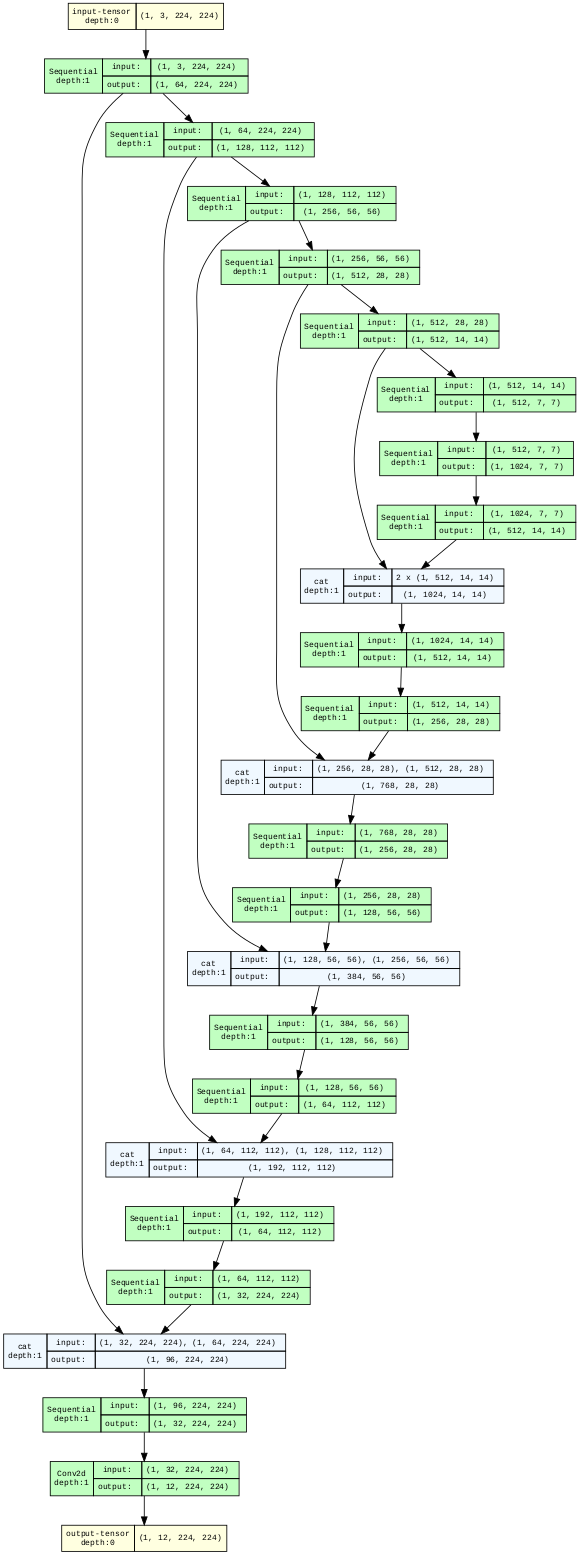

In [15]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(unet_model, input_size=(1,3,224,224), expand_nested=True, graph_name="unet_model", save_graph=True, depth=1)
model_graph.visual_graph

#**Train model**

In [16]:
def train(model, model_in, optimizer, criterion):
  model.to(device)
  model.train()
  ims, masks=model_in
  masks_pred= model(ims)
  loss, acc=criterion(masks_pred, masks)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item(), acc

In [17]:
@torch.no_grad()
def test(model, model_in, criterion, scheduler):
  model.eval()
  with torch.no_grad():
    ims, masks=model_in
    masks_pred= model(ims)
    loss, acc=criterion(masks_pred, masks)
    scheduler.step(loss)

  return loss.item(), acc

In [18]:
criterion=unet_model.calc_loss
optimizer=torch.optim.Adam(params=unet_model.parameters())
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, verbose=True)
EPOCHS=50
log=Report(EPOCHS)

In [19]:
from tqdm.auto import tqdm
for epoch in tqdm(range(EPOCHS)):

  n=len(train_dataloader)
  for ix, inputs in enumerate(train_dataloader):
    loss, acc=train(unet_model, inputs, optimizer, criterion)
    pos=epoch+(ix+1)/n
    log.record(pos=pos, train_loss=loss, train_acc=acc, end="\r")

  n=len(test_dataloader)
  for ix, inputs in enumerate(test_dataloader):
    loss, acc=test(unet_model, inputs, criterion, scheduler)
    pos=epoch+(ix+1)/n
    log.record(pos=pos, val_loss=loss, val_acc=acc, end="\r")
  log.report_avgs(epoch+1)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 1.000  train_loss: 1.995  val_acc: 0.319  val_loss: 2.296  train_acc: 0.549  (19.54s - 957.55s remaining)
EPOCH: 2.000  train_loss: 1.524  val_acc: 0.672  val_loss: 1.722  train_acc: 0.789  (34.95s - 838.91s remaining)
EPOCH: 3.000  train_loss: 1.318  val_acc: 0.782  val_loss: 1.328  train_acc: 0.814  (49.63s - 777.47s remaining)
EPOCH: 4.000  train_loss: 1.194  val_acc: 0.785  val_loss: 1.192  train_acc: 0.821  (64.31s - 739.62s remaining)
EPOCH: 5.000  train_loss: 1.099  val_acc: 0.790  val_loss: 1.132  train_acc: 0.830  (79.13s - 712.16s remaining)
EPOCH: 6.000  train_loss: 1.040  val_acc: 0.792  val_loss: 1.097  train_acc: 0.830  (94.50s - 693.02s remaining)
EPOCH: 7.000  train_loss: 0.995  val_acc: 0.780  val_loss: 1.087  train_acc: 0.835  (109.60s - 673.26s remaining)
EPOCH: 8.000  train_loss: 0.956  val_acc: 0.811  val_loss: 1.025  train_acc: 0.837  (124.12s - 651.61s remaining)
EPOCH: 9.000  train_loss: 0.916  val_acc: 0.848  val_loss: 0.990  train_acc: 0.872  (138.81s -

100%|██████████| 151/151 [00:00<00:00, 5810.94it/s]


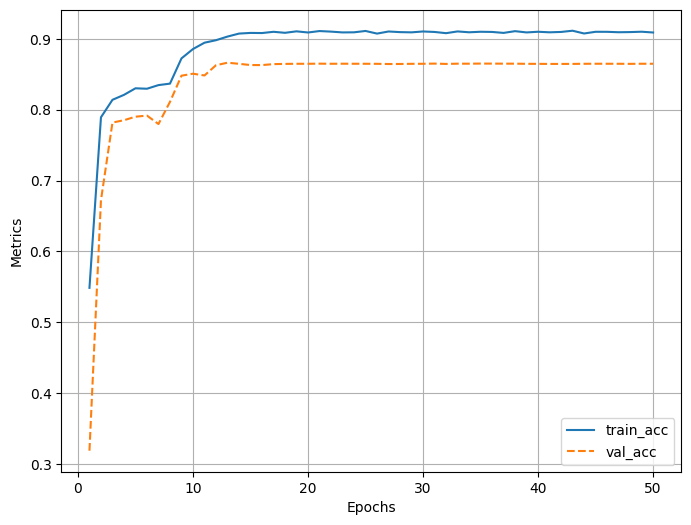

In [20]:
log.plot_epochs(["train_acc","val_acc"])

100%|██████████| 151/151 [00:00<00:00, 8297.83it/s]


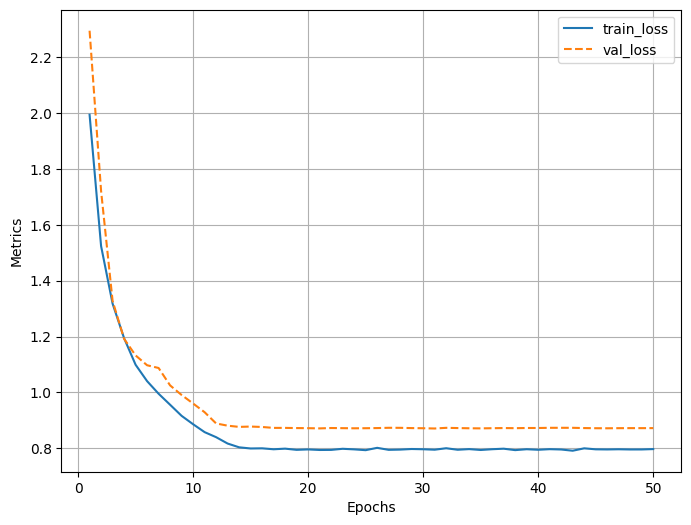

In [21]:
log.plot_epochs(["train_loss","val_loss"])

In [22]:
torch.save(unet_model.state_dict(), "unet_model_save.pth")

In [23]:
!zip -r /content/unet_saved_model.zip /content/unet_model_save.pth

  adding: content/unet_model_save.pth (deflated 7%)


In [24]:
from google.colab import files
files.download("/content/unet_saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Testing**

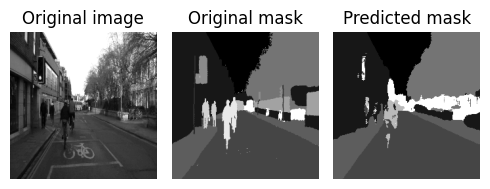

In [25]:
im, mask = next(iter(test_dataloader))
_mask = unet_model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])


In [26]:
import requests
img_links=["https://joujoutravels.com/wp-content/uploads/2021/11/Rue-Saint-Dominique-streets-in-paris-819x1024.jpg",
           "https://www.travisneighborward.com/wp-content/uploads/2016/11/Rue-Cremieux-in-Paris-by-Lydia-Flickr.jpg",
           "https://2.bp.blogspot.com/-9pSwMtVhcTc/VFTBVkKuNII/AAAAAAAA3nc/BM4IhFecqI4/s1600/DSC06189.JPG"]

for id,link in enumerate(img_links):
  request=requests.get(link)
  with open(f"{id}_street.jpg", "wb") as local_file:
    local_file.write(request.content)
    local_file.close

In [44]:
def test_custom_img(img_path, model=unet_model):
  img=cv2.imread(img_path, 1)
  img_o=cv2.resize(img, (224,224))
  img=transformer(img_o)
  img= torch.unsqueeze(img, dim=0).to(device)
  mask=model(img)
  _, mask=torch.max(mask, dim=1)
  subplots([img_o[...,::-1], mask.permute(1,2,0).detach().cpu()[:,:,0]], nc=2, titles=["original", "predicted mask"])

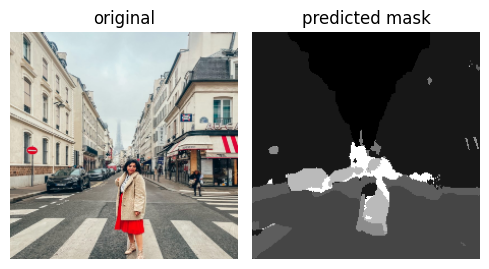

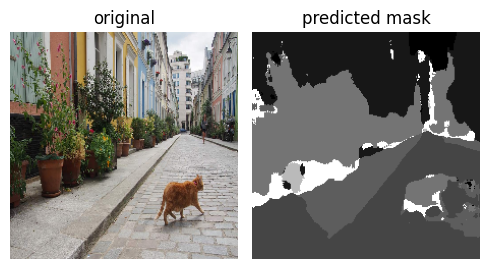

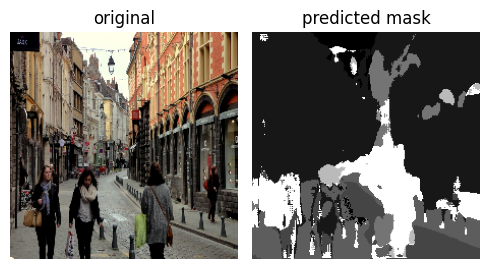

In [47]:
for id in range(3):
  test_custom_img(f"{id}_street.jpg")